# Trend lines of
- [ ] SST
- [ ] TCC
- [ ] LCC
- [ ] U10
- [ ] V10
- [ ] SSH
- [ ] EKE

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy.stats import linregress


In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc', chunks={})
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc', chunks={})
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc', chunks={})
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc', chunks={})
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc', chunks={})

heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})

glorys = xr.open_dataset('glorys_vars.nc', chunks={})

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
heat_fluxes

<xarray.Dataset> Size: 1GB
Dimensions:    (longitude: 69, latitude: 55, time: 10408)
Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [4]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = gom = dict(longitude=slice(-98,-81), latitude=slice(17.5,31))

sst = sst_ds.sea_surface_temperature.sel(**time_slice).resample(time="1D").mean()
tcc = tcc_ds.total_cloud_cover.sel(**time_slice).resample(time="1D").mean()
mslp = mslp_ds.mean_sea_level_pressure.sel(**time_slice).resample(time="1D").mean()
u10 = u10_ds['10m_u_component_of_wind'].sel(**time_slice).resample(time="1D").mean()
v10 = v10_ds['10m_v_component_of_wind'].sel(**time_slice).resample(time="1D").mean()
mask = mask_ds.land_sea_mask
lcc = lcc_ds.lcc.sel(**time_slice).resample(time="1D").mean()

sw = heat_fluxes.ssr / (60*60) #W/m2
lw = heat_fluxes.str / (60*60) #W/m2
sh = heat_fluxes.sshf / (60*60) #W/m2
lh = heat_fluxes.slhf / (60*60) #W/m2

sst_g = glorys.thetao.sel(**gom).isel(depth=0).drop_vars('depth')
ssh = glorys.zos.sel(**gom)
u = glorys.uo.sel(**gom).isel(depth=0).drop_vars('depth')
v = glorys.vo.sel(**gom).isel(depth=0).drop_vars('depth')
eke = 0.5 * (u**2 + v**2)

## Trend lines

In [5]:
def trending(da):
    d = {}
    d['trend_lr'] = linregress(np.arange(0, da.time.size), da.mean(['latitude', 'longitude']))#.fillna(0.))
    d['trend_line_lr'] = (d['trend_lr'][0]*np.arange(0,da.time.size) + d['trend_lr'][1])

    return d

In [6]:
da_names = [sst, tcc, lcc, mslp, u10, v10, sw, lw, sh, lh, sst_g, ssh, u, v, eke] #[0:13]
#name_index 0     1     2    3    4    5    6   7   8   9   10    11  12 13, 14
trend_list = list()
for i in da_names:
    trend_list.append(trending(i))

In [7]:
trend_list[0]['trend_line_lr']

array([26.16048076, 26.16053908, 26.1605974 , ..., 26.76732008,
       26.7673784 , 26.76743672])

In [8]:
trend_list[-1]['trend_lr']

LinregressResult(slope=np.float64(-2.6572447562337703e-07), intercept=np.float64(0.0650834038557511), rvalue=np.float64(-0.06468200840640616), pvalue=np.float64(3.976318185622332e-11), stderr=np.float64(4.018794074373196e-08), intercept_stderr=np.float64(0.00024147440961710902))

In [9]:
def plotting_trend_lines(da, trend_da, ylabel=None, var_title=None,):
    da.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
    plt.plot(da.time, trend_da, color='r', linestyle='dashed')
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlim(da.time.sel(time='1993-01-01', method='nearest'), 
             da.time.sel(time='2021-06-30', method='nearest'))
    plt.title(fr'ERA5 spatially averaged {var_title} (1993-2021)');

In [ ]:
ylabels = ['Temperature (˚C)', '(0-1)', '(0-1)', '(Pa)', '(m $s^{-1}$)', '(m $s^{-1}$)',
           'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'Temperature (˚C)', 'm',
           '(m s$^{-1}$)', '(m s$^{-1}$)', '(m$^2$ s$^{-2}$)',]
var_titles = ['SST', 'TCC', 'LCC', 'MSLP', 'U10', 'V10', 
              'SW', 'LW', 'SH', 'LH', 'SST_g', 'SSH', 'U', 'V', 'EKE']
for (i,j,k,l) in zip(da_names, np.arange(0,14), ylabels, var_titles):
    plotting_trend_lines(i, trend_list[j]['trend_line_lr'], k, l)

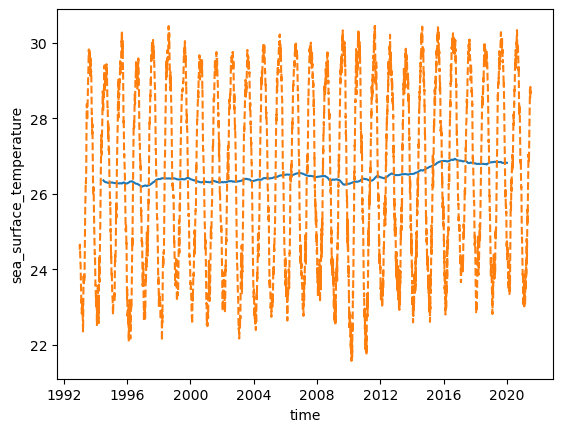

In [7]:
#rolling window is 3 yrs
sst.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst.mean(['latitude', 'longitude']).plot(linestyle='dashed')

In [8]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend_lr = linregress(np.arange(0,249792), sst.mean(['latitude', 'longitude']))#.fillna(0.))

In [9]:
trend_lr

LinregressResult(slope=np.float64(2.4300805680235704e-06), intercept=np.float64(26.160452612650786), rvalue=np.float64(0.07130823345716336), pvalue=np.float64(6.868776951856365e-279), stderr=np.float64(6.801214780155509e-08), intercept_stderr=np.float64(0.009808511009196308))

In [10]:
trend_line_lr = (trend_lr[0]*np.arange(0,249792) + trend_lr[1])

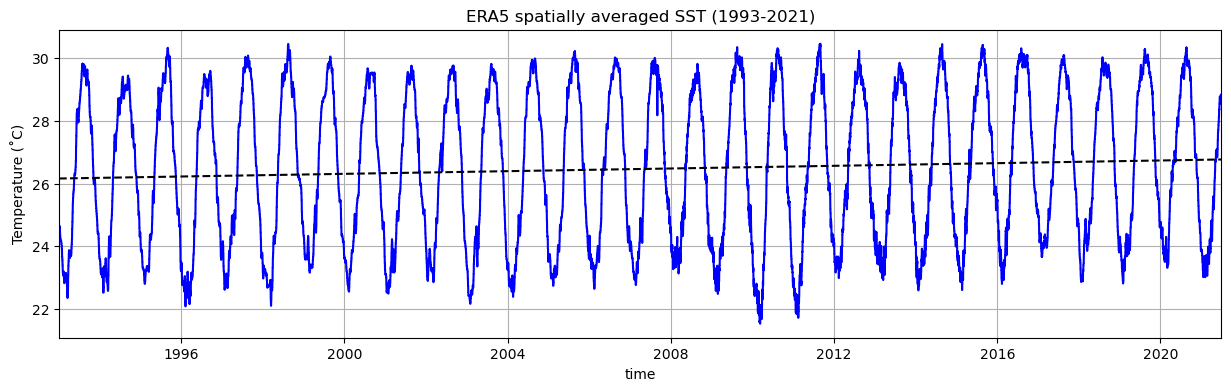

In [11]:
sst.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst.time, trend_line_lr, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.title('ERA5 spatially averaged SST (1993-2021)');

In [12]:
print('Spatially averaged rate of SST increase over 1993-2021:', 
      (trend_line_lr[-1] - trend_line_lr[0]) / (2021-1993), 
      '˚C/yr')

Spatially averaged rate of SST increase over 1993-2021: 0.021679009113113473 ˚C/yr


## Find windows of time where SST increase is highest

In [13]:
sst_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/sst.nc')
sst = sst_ds.sea_surface_temperature
sst_dai = sst.resample(time="1D").mean()

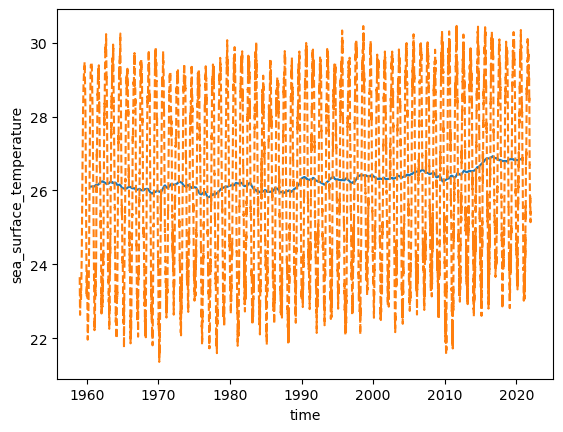

In [14]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')

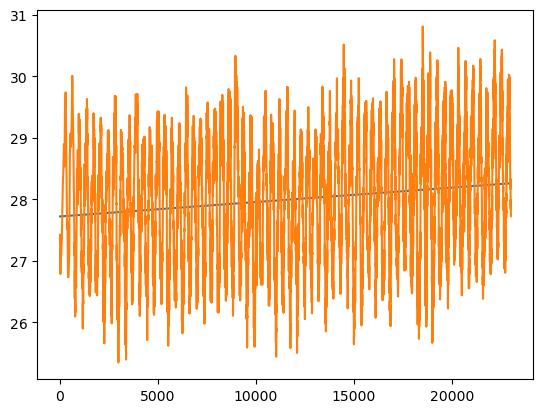

In [15]:
#get a sense of magnitude of trend slope at a single grid pt
z = np.polyfit(np.arange(1,23012), sst_dai[:,50, 50], 1)
p = np.poly1d(z)
plt.plot(np.arange(1,23012), p(np.arange(1,23012)))
plt.plot(np.arange(1,23012), sst_dai[:,50,50])

In [16]:
aw = sst_dai.polyfit('time', deg=1, skipna = True)

In [17]:
aw.polyfit_coefficients.mean(['latitude', 'longitude'])

<xarray.DataArray 'polyfit_coefficients' (degree: 2)> Size: 16B
array([4.08867959e-19, 2.60086574e+01])
Coordinates:
  * degree   (degree) int64 16B 1 0

In [28]:
from scipy.stats import linregress
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend_lr = linregress(np.arange(0,23011), sst_dai.mean(['latitude', 'longitude']))#.fillna(0.))

In [35]:
trend_line_lr = (trend_lr[0]*np.arange(0,23011) + trend_lr[1])

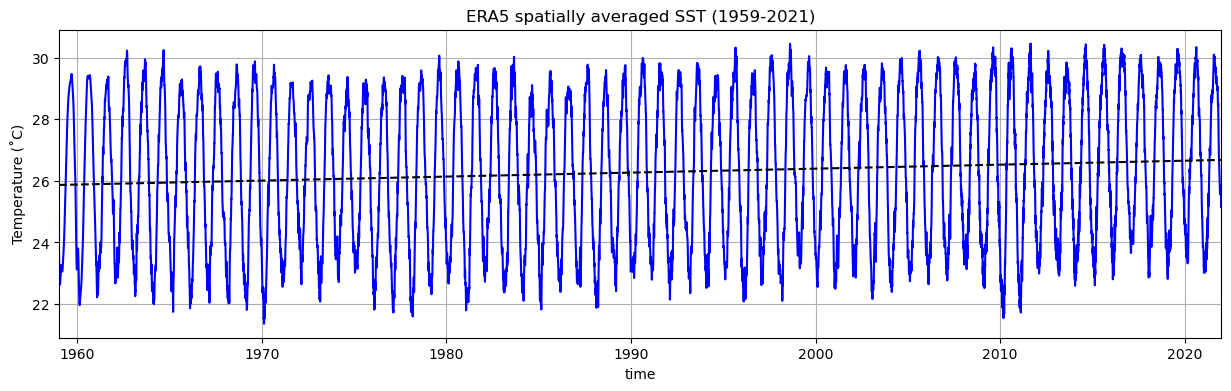

In [37]:
sst_dai.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst_dai.time, trend_line_lr, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst.time.sel(time='1959-01-01', method='nearest'), 
         sst.time.sel(time='2021-12-31', method='nearest'))
plt.title('ERA5 spatially averaged SST (1959-2021)');

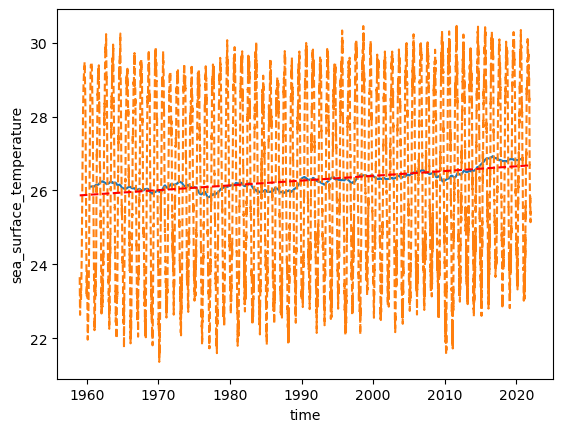

In [38]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')
plt.plot(sst_dai.time, trend_line_lr, color='r', linestyle='dashed')

In [39]:
#two ways to find the windows of time where sst increase was fastest/highest
#Method A: Take the difference between the rolling average curve and trend line
sst_roll = sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude'])
roll_minus_trend = sst_roll - trend_line_lr
#Method B: take derivate of the rolling average curve
dt = (sst_roll.time.diff('time') / 1e9).astype('f4')
dydx = sst_roll.diff('time') / dt

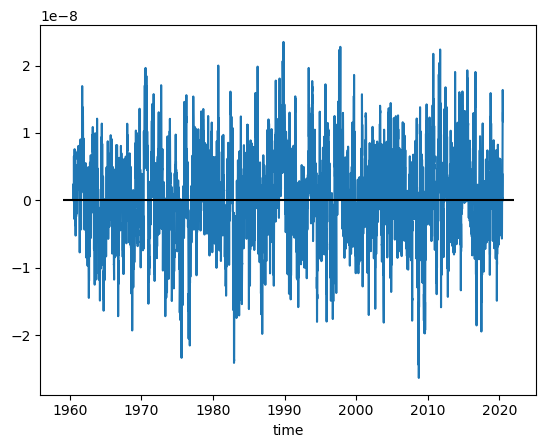

In [40]:
(dydx).plot()
plt.hlines(y=0, xmin=dydx.time[0], xmax=dydx.time[-1], color='k');

In [41]:
d2ydx2 = dydx.diff('time') / (dt**2)

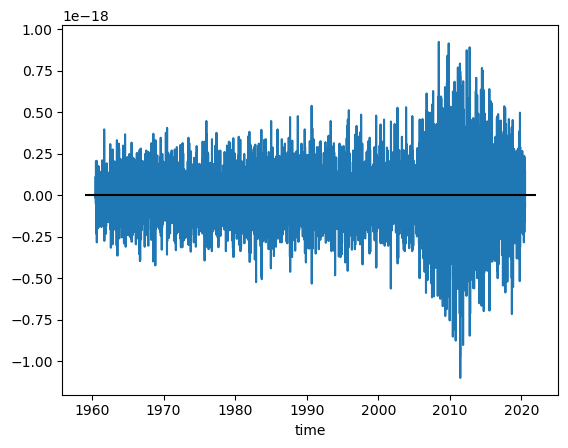

In [42]:
d2ydx2.plot()
plt.hlines(y=0, xmin=d2ydx2.time[0], xmax=d2ydx2.time[-1], color='k');

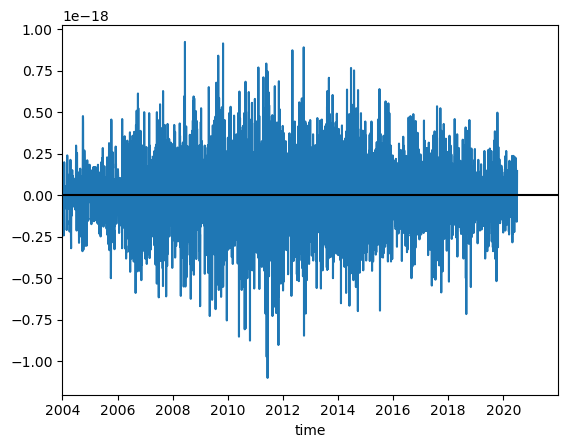

In [43]:
d2ydx2.plot()
plt.hlines(y=0, xmin=d2ydx2.time[0], xmax=d2ydx2.time[-1], color='k')
plt.xlim(d2ydx2.time.sel(time='2004', method='nearest'), d2ydx2.time.isel(time=-1));

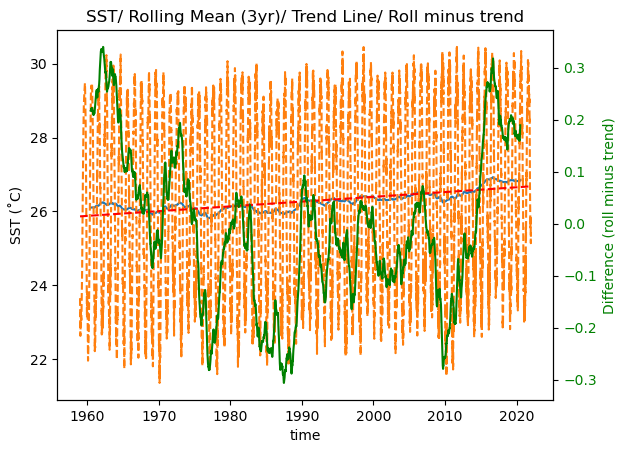

In [45]:
fig, ax0 = plt.subplots()
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot(ax=ax0)
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed', ax=ax0)
ax0.plot(sst_dai.time, trend_line_lr, color='r', linestyle='dashed')
ax0.tick_params(axis='y', labelcolor='k')
ax0.set_ylabel('SST (˚C)')
ax1 = ax0.twinx()  # Create a twin Axes sharing the x-axis
roll_minus_trend.plot(color='green', ax=ax1)
ax1.set_ylabel('Difference (roll minus trend)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
plt.title('SST/ Rolling Mean (3yr)/ Trend Line/ Roll minus trend');